In [34]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import KFold


In [35]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.bottleneck = self.conv_block(512, 1024)
        self.dec4 = self.conv_block(1024 + 512, 512)
        self.dec3 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.dec4(self.up(bottleneck, enc4))
        dec3 = self.dec3(self.up(dec4, enc3))
        dec2 = self.dec2(self.up(dec3, enc2))
        dec1 = self.dec1(self.up(dec2, enc1))
        output = torch.sigmoid(self.final(dec1))
        return output

    def pool(self, x):
        return nn.MaxPool2d(kernel_size=2, stride=2)(x)

    def up(self, x1, x2):
        x1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                          diffY // 2, diffY - diffY // 2])
        return torch.cat([x2, x1], dim=1)


In [36]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask


In [37]:
data_transform = transforms.Compose([
    transforms.ToTensor()
])


In [38]:
def load_and_preprocess(image_files, mask_files, image_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0  
        
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0  
        mask = np.expand_dims(mask, axis=-1) 
        
        images.append(img)
        masks.append(mask)
    
    images = np.array(images)
    masks = np.array(masks)
    return images, masks


In [39]:
image_dir = 'SOS_Images/Images'
mask_dir = 'SOS_Images/Masks'

image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.jpg')]

images, masks = load_and_preprocess(image_files, mask_files, image_dir, mask_dir)

dataset = SegmentationDataset(images, masks, transform=data_transform)


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCELoss()
optimizer = optim.Adam


In [41]:
# Dice Coefficient
def dice_coeff(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    
    return dice.mean()


In [42]:
# IoU
def iou(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.mean()


In [50]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    val_losses = []
    val_dices = []
    val_ious = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_dice += dice_coeff(outputs, masks).item() * images.size(0)
            train_iou += iou(outputs, masks).item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        train_dice /= len(train_loader.dataset)
        train_iou /= len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                val_dice += dice_coeff(outputs, masks).item() * images.size(0)
                val_iou += iou(outputs, masks).item() * images.size(0)
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)

        val_losses.append(val_loss)
        val_dices.append(val_dice)
        val_ious.append(val_iou)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")

    return val_losses, val_dices, val_ious


In [51]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 0
all_val_losses = []
all_val_dices = []
all_val_ious = []

for train_index, val_index in kf.split(dataset):
    fold += 1
    print(f"Fold {fold}")

    train_subset = torch.utils.data.Subset(dataset, train_index)
    val_subset = torch.utils.data.Subset(dataset, val_index)
    
    train_loader = DataLoader(train_subset, batch_size=2, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=2, shuffle=False)
    
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    val_losses, val_dices, val_ious = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100)
    
    all_val_losses.extend(val_losses)
    all_val_dices.extend(val_dices)
    all_val_ious.extend(val_ious)


Fold 1
Epoch 1/100, Train Loss: 1.0612, Train Dice: 0.8294, Train IoU: 0.7423
Epoch 1/100, Val Loss: 0.0434, Val Dice: 0.9939, Val IoU: 0.9879
Epoch 2/100, Train Loss: 0.2695, Train Dice: 0.8723, Train IoU: 0.7924
Epoch 2/100, Val Loss: 0.3399, Val Dice: 0.9950, Val IoU: 0.9901
Epoch 3/100, Train Loss: 0.1834, Train Dice: 0.9909, Train IoU: 0.9821
Epoch 3/100, Val Loss: 0.0426, Val Dice: 0.9880, Val IoU: 0.9762
Epoch 4/100, Train Loss: 0.0449, Train Dice: 0.9893, Train IoU: 0.9789
Epoch 4/100, Val Loss: 0.0416, Val Dice: 0.9927, Val IoU: 0.9855
Epoch 5/100, Train Loss: 0.0457, Train Dice: 0.9900, Train IoU: 0.9801
Epoch 5/100, Val Loss: 0.0412, Val Dice: 0.9905, Val IoU: 0.9812
Epoch 6/100, Train Loss: 0.0450, Train Dice: 0.9893, Train IoU: 0.9788
Epoch 6/100, Val Loss: 0.0388, Val Dice: 0.9915, Val IoU: 0.9831
Epoch 7/100, Train Loss: 0.0419, Train Dice: 0.9905, Train IoU: 0.9812
Epoch 7/100, Val Loss: 0.0386, Val Dice: 0.9943, Val IoU: 0.9886
Epoch 8/100, Train Loss: 0.0411, Train Di

In [52]:
mean_val_loss = np.mean(all_val_losses)
mean_val_dice = np.mean(all_val_dices)
mean_val_iou = np.mean(all_val_ious)

print(f"Mean Val Loss: {mean_val_loss:.4f}, Mean Val Dice: {mean_val_dice:.4f}, Mean Val IoU: {mean_val_iou:.4f}")


Mean Val Loss: 0.6330, Mean Val Dice: 0.9923, Mean Val IoU: 0.9853


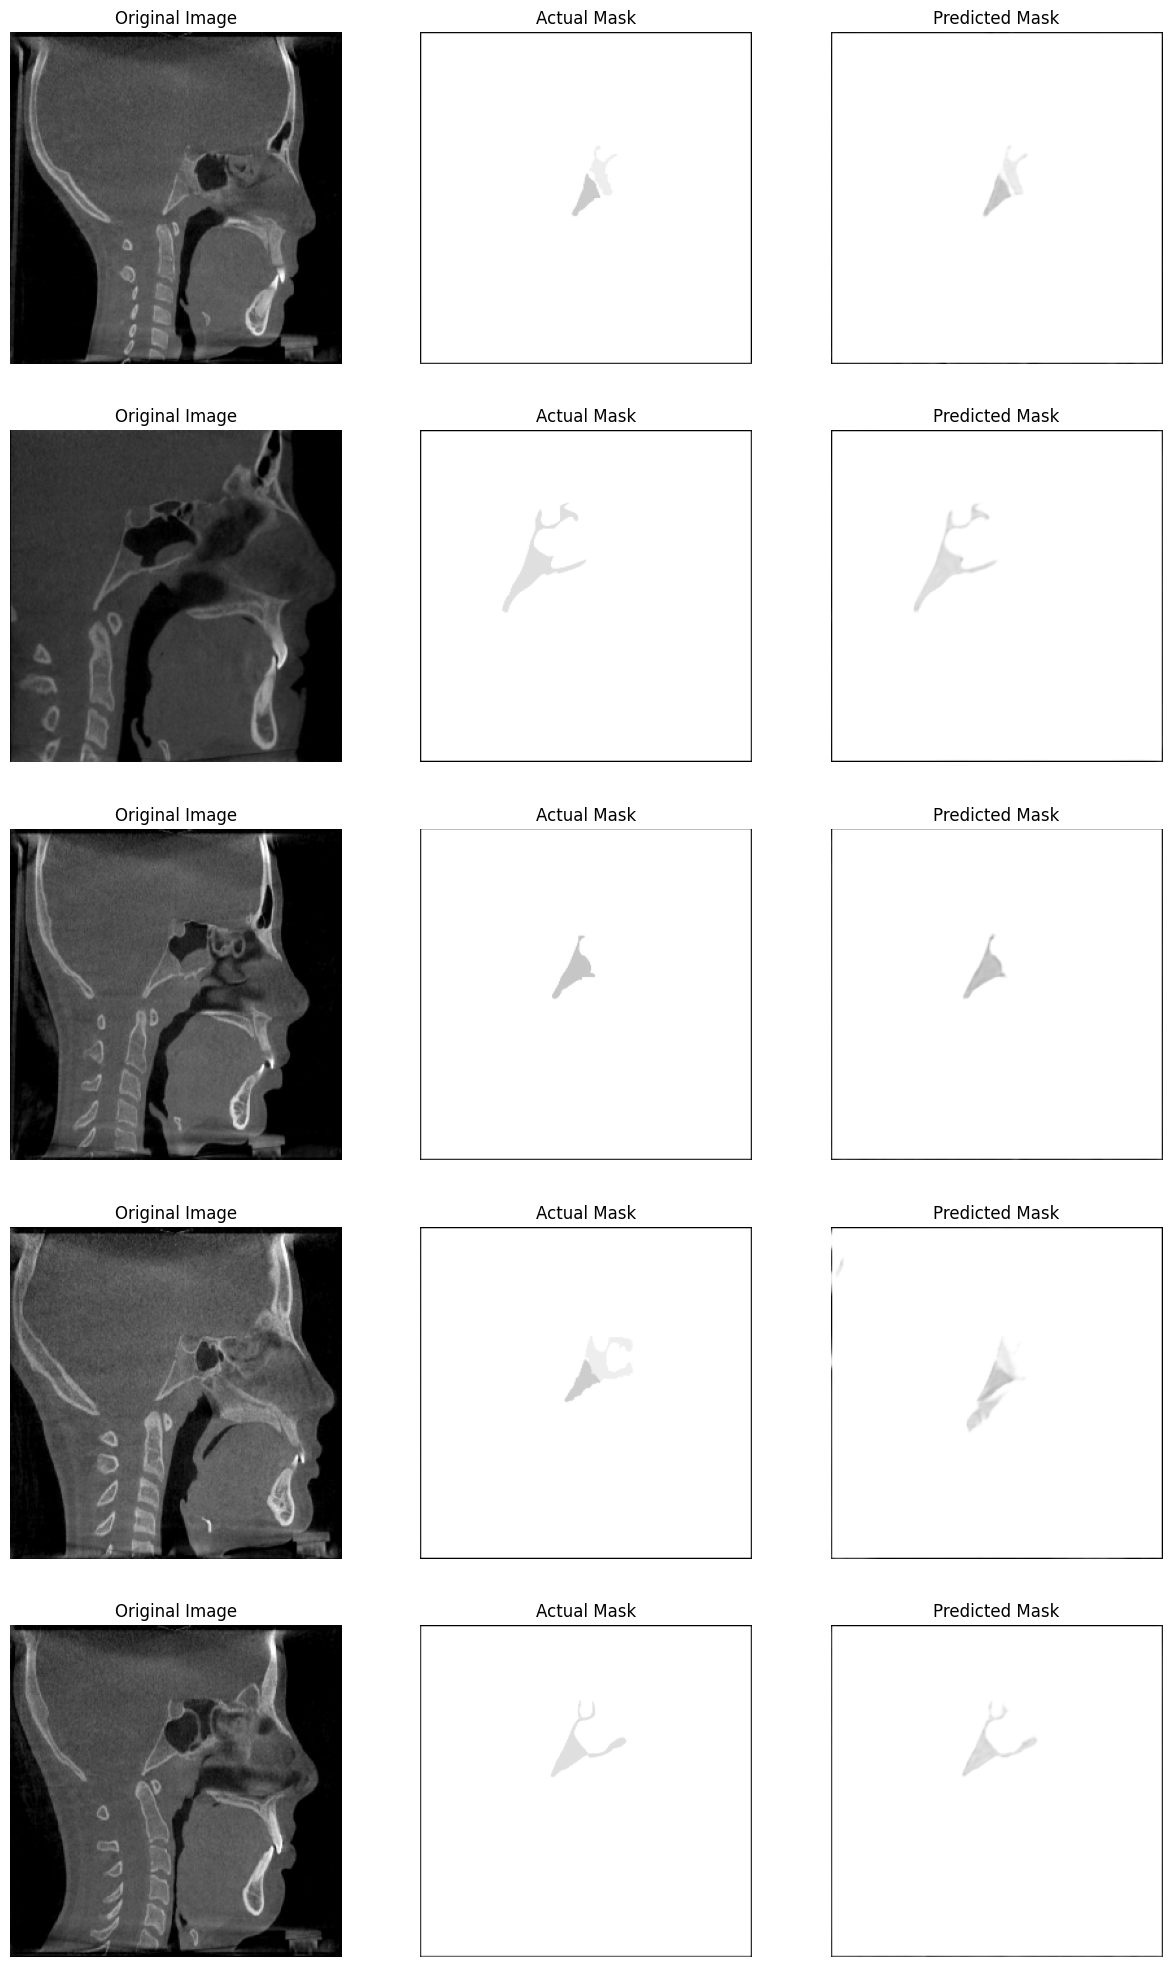

In [22]:
import matplotlib.pyplot as plt

def show_predictions(model, data_loader, num_images=5):
    model.eval()
    images, masks, preds = [], [], []
    with torch.no_grad():
        for i, (image, mask) in enumerate(data_loader):
            if i == num_images:
                break
            image = image.to(device, dtype=torch.float32)
            output = model(image)
            images.append(image.cpu().numpy()[0])
            masks.append(mask.numpy()[0])
            preds.append(output.cpu().numpy()[0])

    fig, axs = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        axs[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
        axs[i, 0].set_title("Original Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(masks[i].squeeze(), cmap="gray")
        axs[i, 1].set_title("Actual Mask")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(preds[i].squeeze(), cmap="gray")
        axs[i, 2].set_title("Predicted Mask")
        axs[i, 2].axis("off")

    plt.show()

subset_indices = list(range(10))  
subset = torch.utils.data.Subset(dataset, subset_indices)
subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

# Show predictions
show_predictions(model, subset_loader, num_images=5)
